In [2]:
## import public packages
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import multivariate_normal
import time
import pickle
import os

## import self-written packages 
from adafdr.util import *
import adafdr.method as md
import adafdr.data_loader as dl

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
output_folder = '/home/martin/NeuralFDR2/figures/fig_schema'
np.random.seed(0)
n_null = 500
n_alt = 100
n_sample = n_alt + n_null
x = np.zeros([n_sample], dtype=float)
p = np.zeros([n_sample], dtype=float)
h = np.zeros([n_sample], dtype=bool)
# Assign values 
h[:n_alt] = True
z_null = np.random.randn(n_null)
p[~h] = 1 - stats.norm.cdf(z_null)
x[~h] = np.random.rand(n_null)
z_alt = np.random.randn(n_alt) + 2.25
p[h] = 1 - stats.norm.cdf(z_alt)
x[h] = (np.random.randn(n_alt)*0.15+0.75).clip(min=0, max=1)

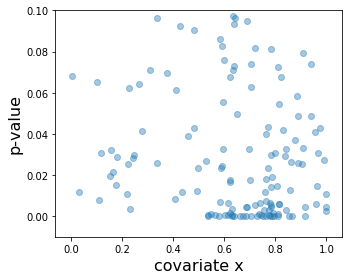

In [4]:
filename = 'p_value'
plt.figure(figsize=[5,4])
plt.scatter(x, p, alpha=0.4, color = 'C0')
plt.ylim([-0.01, 0.1])
plt.xlabel('covariate x', fontsize=16)
plt.ylabel('p-value', fontsize=16)
plt.tight_layout()
plt.savefig(output_folder+'/'+'%s.png'%filename)
plt.savefig(output_folder+'/'+'%s.pdf'%filename)
plt.show()

D=58, FD=6, FDP=0.103


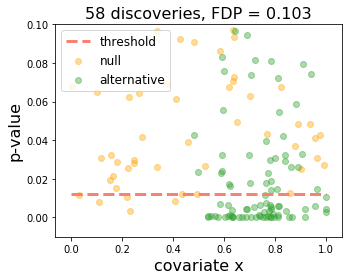

D=79, FD=8, FDP=0.101


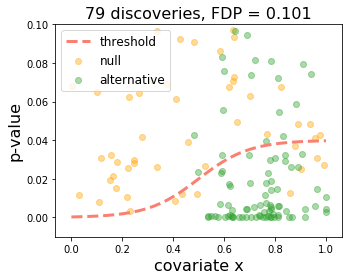

In [5]:
def plot_thres(thres, p, h, x, filename=None, output_folder = output_folder):
    D = np.sum(p<=thres) 
    TD = np.sum(p[h]<=thres[h])
    FD = np.sum(p[~h]<=thres[~h])
    print('D=%d, FD=%d, FDP=%0.3f'%(D, FD, FD/D))
    plt.figure(figsize=[5,4])
    sort_ind = np.argsort(x)   
    plt.plot(x[sort_ind], thres[sort_ind], color = 'salmon', linestyle='--',\
             linewidth=3, label='threshold')
    plt.scatter(x[~h], p[~h], alpha=0.4, color = 'orange', label='null')
    plt.scatter(x[h], p[h], alpha=0.4, color = 'C2', label='alternative') 
    plt.ylim([-0.01, 0.1])
    plt.legend(loc='upper left', fontsize=12)
    plt.xlabel('covariate x', fontsize=16)
    plt.ylabel('p-value', fontsize=16)
    plt.title('%d discoveries, FDP = %0.3f'%(D, FD/D), fontsize=16)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(output_folder+'/'+'%s.png'%filename)
        plt.savefig(output_folder+'/'+'%s.pdf'%filename)
    plt.show()
    
thres = 0.012*np.ones([n_sample], dtype=float)
plot_thres(thres, p, h, x, filename = 'decision_nonadapt')
a = 10
thres = 0.04/(np.exp(a*(-x+0.5)) + 1)
plot_thres(thres, p, h, x, filename = 'decision_adapt')

# figure_alg

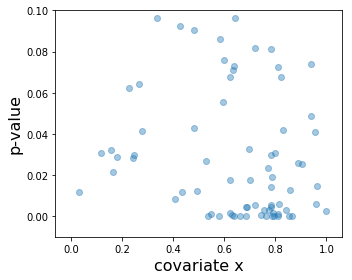

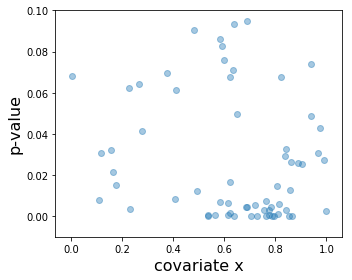

In [6]:
def plot_data(p, x, title='p_value'):
    filename = title
    plt.figure(figsize=[5,4])
    plt.scatter(x, p, alpha=0.4, color = 'C0')
    plt.ylim([-0.01, 0.1])
    plt.xlabel('covariate x', fontsize=16)
    plt.ylabel('p-value', fontsize=16)
    plt.tight_layout()
    plt.savefig(output_folder+'/'+'%s.png'%filename)
    plt.savefig(output_folder+'/'+'%s.pdf'%filename)
    plt.show()
# Hypothesis splitting
ind_fold = np.zeros([n_sample], dtype=bool)
rand_ind = np.random.permutation(n_sample)[:int(n_sample/2)]
ind_fold[rand_ind] = True
plot_data(p[~rand_ind], x[~rand_ind], title='p_value_fold_0')
plot_data(p[rand_ind], x[rand_ind], title='p_value_fold_1')

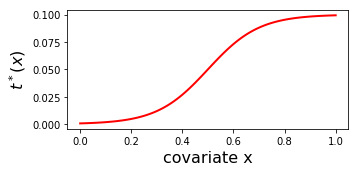

In [7]:
# learn a threshold 
x_axis = np.arange(101)/100
thres = 0.1/(np.exp(a*(-x_axis+0.5)) + 1)
filename = 'threshold_learning'
plt.figure(figsize=[5, 2.5])
plt.plot(x_axis, thres, linewidth='2', color='r')
# plt.ylim([-0.01, 0.1])
plt.xlabel('covariate x', fontsize=16)
plt.ylabel('$t^*(x)$', fontsize=16)
plt.tight_layout()
plt.savefig(output_folder+'/'+'%s.png'%filename)
plt.savefig(output_folder+'/'+'%s.pdf'%filename)
plt.show()

0.25 0.18181818181818182
0.175 0.1
0.03571428571428571 0.07142857142857142


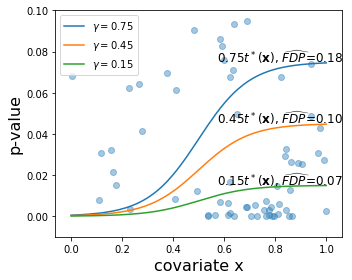

In [8]:
# rescale
thres = 0.1/(np.exp(a*(-x[ind_fold]+0.5)) + 1)
filename = 'rescale'
plt.figure(figsize=[5,4])
plt.scatter(x[ind_fold], p[ind_fold], alpha=0.4, color = 'C0')
ind_sort = np.argsort(x[ind_fold])
gamma_list = [0.75, 0.45, 0.15]
for gamma in gamma_list:
    plt.plot(x[ind_fold][ind_sort], gamma * thres[ind_sort], label='$\gamma=%0.2f$'%gamma)
    D = np.sum(p[ind_fold] <= gamma*thres)
    FD = np.sum((p[ind_fold] <= gamma*thres)*~h[ind_fold])
    FD_hat = np.sum((p[ind_fold] >= 1- gamma*thres))
    plt.annotate('%0.2f$t^*(\mathbf{x})$, $\widehat{FDP}$=%0.2f'%(gamma, FD_hat/D),\
                 [0.57, gamma/10], fontsize=12)
#     plt.annotate('$\widehat{FDP}$=%0.2f'%(FD_hat/D),\
#              [0.75, gamma - 0.01], fontsize=12)
    print(FD/D, FD_hat/D)
# plt.plot(x[ind_fold][ind_sort], 0.04 * thres[ind_sort], color='r')
# plt.plot(x[ind_fold][ind_sort], 0.02 * thres[ind_sort], )
plt.ylim([-0.01, 0.1])
plt.xlabel('covariate x', fontsize=16)
plt.ylabel('p-value', fontsize=16)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(output_folder+'/'+'%s.png'%filename)
plt.savefig(output_folder+'/'+'%s.pdf'%filename)
plt.show()

0.25 0.18181818181818182


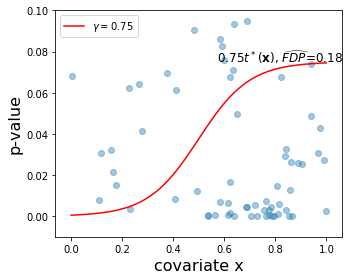

0.175 0.1


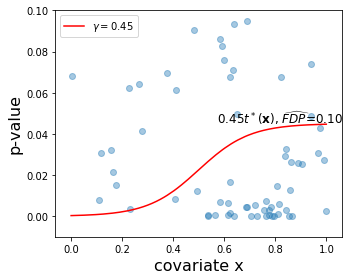

0.03571428571428571 0.07142857142857142


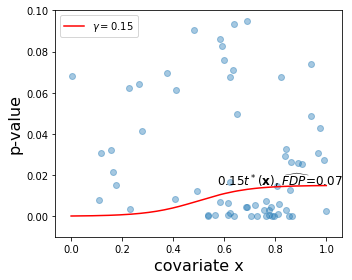

In [17]:
# rescale
thres = 0.1/(np.exp(a*(-x[ind_fold]+0.5)) + 1)
filename = 'rescale'
gamma_list = [0.75, 0.45, 0.15]
for gamma in gamma_list:
    plt.figure(figsize=[5,4])
    plt.scatter(x[ind_fold], p[ind_fold], alpha=0.4, color = 'C0')
    ind_sort = np.argsort(x[ind_fold])
    plt.plot(x[ind_fold][ind_sort], gamma * thres[ind_sort], label='$\gamma=%0.2f$'%gamma,
             color='r')
    D = np.sum(p[ind_fold] <= gamma*thres)
    FD = np.sum((p[ind_fold] <= gamma*thres)*~h[ind_fold])
    FD_hat = np.sum((p[ind_fold] >= 1- gamma*thres))
    plt.annotate('%0.2f$t^*(\mathbf{x})$, $\widehat{FDP}$=%0.2f'%(gamma, FD_hat/D),\
                 [0.57, gamma/10], fontsize=12)
#     plt.annotate('$\widehat{FDP}$=%0.2f'%(FD_hat/D),\
#              [0.75, gamma - 0.01], fontsize=12)
    print(FD/D, FD_hat/D)
# plt.plot(x[ind_fold][ind_sort], 0.04 * thres[ind_sort], color='r')
# plt.plot(x[ind_fold][ind_sort], 0.02 * thres[ind_sort], )
    plt.ylim([-0.01, 0.1])
    plt.xlabel('covariate x', fontsize=16)
    plt.ylabel('p-value', fontsize=16)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(output_folder+'/'+'%s_%0.1f.png'%(filename, gamma))
    plt.savefig(output_folder+'/'+'%s_%0.1f.pdf'%(filename, gamma))
#     plt.savefig(output_folder+'/'+'%s.pdf'%filename)
    plt.show()

0.39344262295081966 0.3114754098360656 19


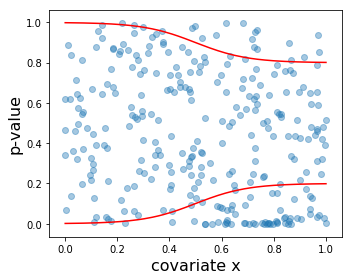

In [14]:
# rescale
thres = 0.1/(np.exp(a*(-x[ind_fold]+0.5)) + 1)
filename = 'rescale_mirror'
plt.figure(figsize=[5,4])
plt.scatter(x[ind_fold], p[ind_fold], alpha=0.4, color = 'C0')
ind_sort = np.argsort(x[ind_fold])
# gamma_list = [0.75, 0.45, 0.15]
gamma_list = [2]
for gamma in gamma_list:
    plt.plot(x[ind_fold][ind_sort], gamma * thres[ind_sort], label='$\gamma=%0.2f$'%gamma,
             color='r')
    plt.plot(x[ind_fold][ind_sort], 1-gamma * thres[ind_sort], label='$\gamma=%0.2f$'%gamma,
             color='r')
    D = np.sum(p[ind_fold] <= gamma*thres)
    FD = np.sum((p[ind_fold] <= gamma*thres)*~h[ind_fold])
    FD_hat = np.sum((p[ind_fold] >= 1- gamma*thres))
#     plt.annotate('%0.2f$t^*(\mathbf{x})$, $\widehat{FDP}$=%0.2f'%(gamma, FD_hat/D),\
#                  [0.57, gamma/10], fontsize=12)
#     plt.annotate('$\widehat{FDP}$=%0.2f'%(FD_hat/D),\
#              [0.75, gamma - 0.01], fontsize=12)
    print(FD/D, FD_hat/D, FD_hat)
# plt.plot(x[ind_fold][ind_sort], 0.04 * thres[ind_sort], color='r')
# plt.plot(x[ind_fold][ind_sort], 0.02 * thres[ind_sort], )
# plt.ylim([-0.01, 0.1])
plt.xlabel('covariate x', fontsize=16)
plt.ylabel('p-value', fontsize=16)
# plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(output_folder+'/'+'%s.png'%filename)
plt.savefig(output_folder+'/'+'%s.pdf'%filename)
plt.show()